# <p style="background-color:blue;font-family:newtimeroman;color:#FFF9ED;font-size:200%;text-align:center;border-radius:10px 10px;">Sign Classification using Deep Learning</p>

<p style="font-family:newtimeroman;font-size:120%;color:#F47340;">I hope this kernel helpful and some UPVOTES would be very much appreciated</p>

<a id='top'></a>
<p style="background-color:blue;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">TABLE OF CONTENTS</p>   
    
* [IMPORTING LIBRARIES](#1)

* [LOADING DATA](#2)

* [BUILDING MODEL](#3)

* [TRANSFER LEARNING USING INCEPTIONV3](#4)

* [PLOTTING MODEL TRAINING AND VALIDATION RESULT](#5)

* [SAVING MODEL](#6)



<a id="1"></a>
# <p style="background-color:blue;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">IMPORTING LIBRARIES</p>

<p style="font-family:newtimeroman;color:#F47340;font-size:150%">The following Libraries will be used in the notebook.</p>

In [3]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

<a id="2"></a>
# <p style="background-color:blue;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">LOADING DATA</p>

<p style="font-family:newtimeroman;color:#F47340;font-size:150%">
    Here I will using Yoga Pose Image datasets. This dataset contains 2515 images and 36 different signa.
</p>

In [4]:
data_dir = 'asl_dataset/'

data = tf.keras.preprocessing.image_dataset_from_directory(data_dir)

Found 5030 files belonging to 37 classes.


In [5]:
#Filtering out corrupted images

import os
num_skipped = 0
for folder_name in ("0","1","2","3","4","5","6","7","8","9","a","b","c","d","e","f","g","h","i","j","k","l","m","n","o"
                    ,"p","q","r","s","t","u","v","w","x","y","z"):
    folder_path = os.path.join(data_dir, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()
        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
print("Deleted %d images" % num_skipped)

Deleted 0 images


In [6]:
# Create an ImageDataGenerator and do Image Augmentation
datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 40,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        fill_mode = 'nearest',
        validation_split = 0.2)

In [7]:
height = 228
width = 228
channels = 3
batch_size = 32
img_shape = (height, width, channels)
img_size = (height, width)

In [8]:
train_data = datagen.flow_from_directory(
    data_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training')

val_data = datagen.flow_from_directory(
    data_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode='categorical',
    subset = 'validation')

Found 4024 images belonging to 37 classes.
Found 1006 images belonging to 37 classes.


In [9]:
num_classes = len(data.class_names)
print('.... Number of Classes : {0} ....'.format(num_classes))

.... Number of Classes : 37 ....


<p style="font-family:newtimeroman;color:#F47340;font-size:150%">
    Now that I have the dataset loaded, let us have a look at a few images.
</p>

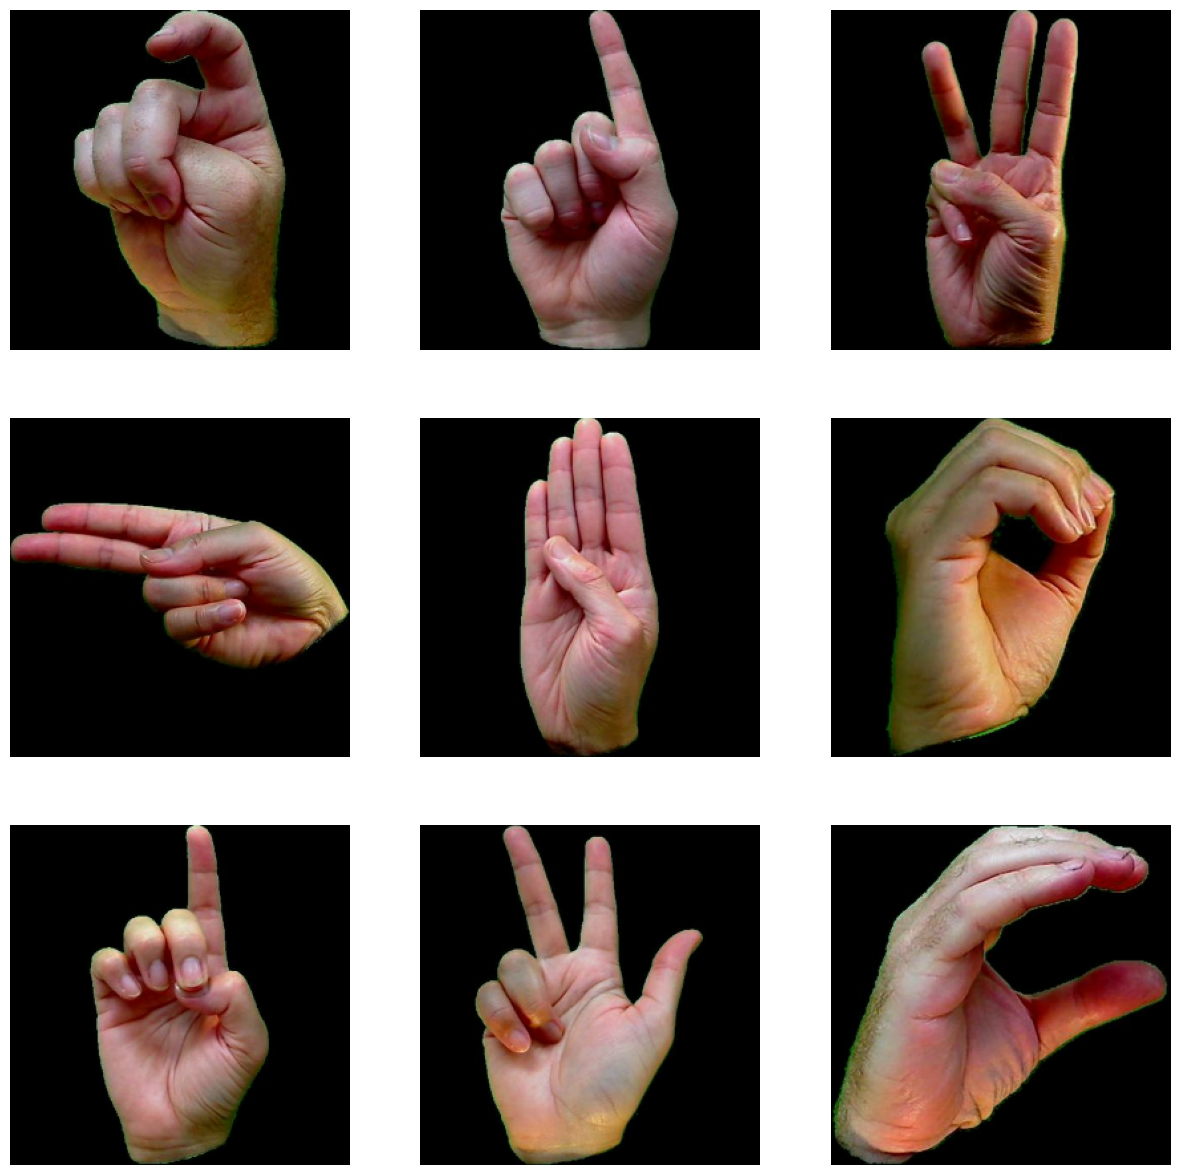

In [10]:
#Defing a function to see images
def show_img(data):
    plt.figure(figsize=(15,15))
    for images, labels in data.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.axis("off")

#Plotting the images in dataset
show_img(data)

<a id="3"></a>
# <p style="background-color:blue;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">BUILDING MODEL</p>

<p style="font-family:newtimeroman;color:#F47340;font-size:150%">
    Here I will be using pre-trained model, which can be done using Transfer Learning. The reuse of a previously learned model on a new problem is known as transfer learning. It’s particularly popular in deep learning right now since it can train deep neural networks with a small amount of data. This is particularly valuable in the field of data science, as most real-world situations do not require millions of labelled data points to train complicated models. 
</p>

Reference : [Analytics Vidhya](https://www.analyticsvidhya.com/blog/2021/10/understanding-transfer-learning-for-deep-learning/)

<a id="4"></a>
# <p style="background-color:blue;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">TRANSFER LEARNING USING INCEPTION V3</p>

<p style="font-family:newtimeroman;color:#F47340;font-size:150%">

Inception is a convolutional neural network architecture introduced by Google which achieved top results in ImageNet Large Scale Visual Recognition Challenge 2014.
    
</p>

![](https://camo.githubusercontent.com/d93725579fc7e7140a60faadaaf47ae93eda84b6/68747470733a2f2f7777772e50657465724d6f7373416d6c416c6c52657365617263682e636f6d2f6d656469612f696d616765732f7265706f7369746f726965732f434e4e2e6a7067)

Image Source: [Intel](https://www.intel.com/content/www/us/en/developer/articles/technical/inception-v3-deep-convolutional-architecture-for-classifying-acute-myeloidlymphoblastic.html)

## Training Model

In [11]:
# load pre-trained InceptionV3
pre_trained = InceptionV3(weights='imagenet', include_top=False, input_shape=img_shape, pooling='avg')

for layer in pre_trained.layers:
    layer.trainable = False

In [12]:
x = pre_trained.output
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs = pre_trained.input, outputs = predictions)
model.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 228, 228, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 113, 113, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 113, 113, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 113, 113, 32)         0         ['batch_normalization[0][0

In [14]:
STEP_SIZE_TRAIN = train_data.n // train_data.batch_size
STEP_SIZE_VALID = val_data.n // val_data.batch_size

history = model.fit_generator(train_data,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = val_data,
                    validation_steps = STEP_SIZE_VALID,
                    epochs = 1,
                    verbose = 1)

C:\Users\Ganesha\AppData\Local\Temp\ipykernel_5016\3091559728.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_data,




125/125 [==============================] - 297s 2s/step - loss: 2.9731 - accuracy: 0.3800 - val_loss: 2.2554 - val_accuracy: 0.4073


<a id="5"></a>
# <p style="background-color:blue;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">PLOTTING MODEL TRAINING AND VALIDATION RESULT</p>

Text(0.5, 1.0, 'Model Loss')

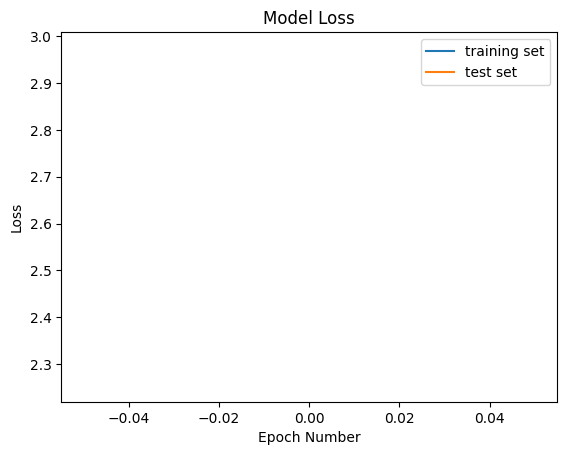

In [22]:
import matplotlib.pyplot as plt
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='training set')
plt.plot(history.history['val_loss'], label='test set')
plt.legend()
plt.title('Model Loss')

Text(0.5, 1.0, 'Model Accuracy')

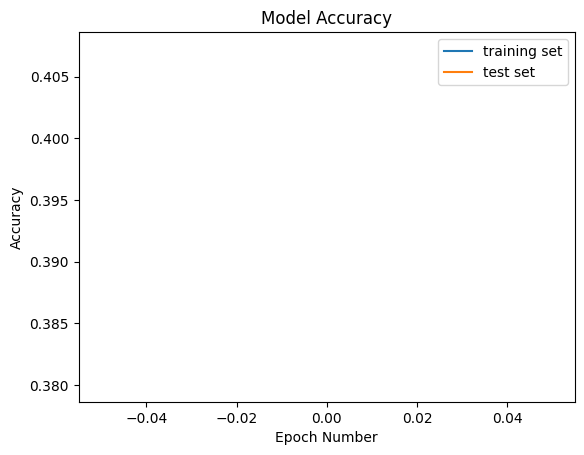

In [23]:
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='training set')
plt.plot(history.history['val_accuracy'], label='test set')
plt.legend()
plt.title('Model Accuracy')

<a id="6"></a>
# <p style="background-color:blue;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">SAVING MODEL</p>

<p style="font-family:newtimeroman;color:#F47340;font-size:150%">
    Let's save model for future.
</p>

In [17]:
model_name = 'hand_sign_recognition_inceptionV3.h5'
model.save(model_name, save_format='h5')

c:\Users\Ganesha\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<a id="7"></a>
# <p style="background-color:blue;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">PREDICTION</p>

<p style="font-family:newtimeroman;color:#F47340;font-size:150%">
    Let's check how accurate is our model.
</p>

In [18]:
class_map = train_data.class_indices
classes = []
for key in class_map.keys():
    classes.append(key)

In [19]:
def predict_image(filename, model):
    img_ = image.load_img(filename, target_size=(228, 228))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0)
    img_processed /= 255.
    
    prediction = model.predict(img_processed)
    
    index = np.argmax(prediction)
    
    plt.title("Prediction - {}".format(str(classes[index]).title()), size=18, color='red')
    plt.imshow(img_array)

In [20]:
predict_image('/kaggle/input/asl-dataset/asl_dataset/3/hand1_3_left_seg_5_cropped.jpeg', model)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/asl-dataset/asl_dataset/3/hand1_3_left_seg_5_cropped.jpeg'

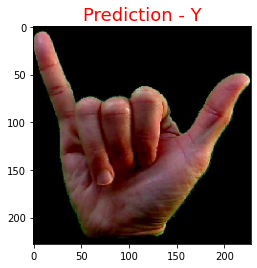

In [ ]:
predict_image('/kaggle/input/asl-dataset/asl_dataset/y/hand1_y_right_seg_1_cropped.jpeg', model)

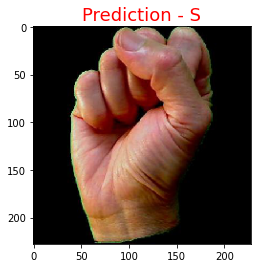

In [ ]:
predict_image('/kaggle/input/asl-dataset/asl_dataset/s/hand1_s_left_seg_4_cropped.jpeg', model)

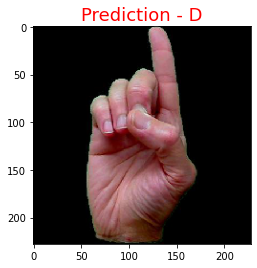

In [ ]:
predict_image('/kaggle/input/asl-dataset/asl_dataset/d/hand1_d_dif_seg_5_cropped.jpeg', model)